In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

%matplotlib inline

Data Loading

In [2]:
hr = pd.read_csv('turnover.csv')

#Explore analysis
hr.info()
hr.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [3]:
# Missing data checking
hr.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [4]:
# List values of categorical columns
categories = {'sales': hr['sales'].unique().tolist(), 'salary': hr['salary'].unique().tolist()}
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1]:
        print('\n')

salary:
['low', 'medium', 'high']


sales:
['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']


In [5]:
# Rename sales column
hr = hr.rename(columns={'sales': 'Department'})
hr = hr.rename(columns={'average_montly_hours': 'average_monthly_hours'})
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# Target proportion
hr['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [7]:
# Get the mean of each variable for employees who left
hr.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Employees who left company have
Lower satisfaction_level: 0.44 vs 0.67
Higher average_monthly_hours: 207 vs 199
Lower work_accident: 0.05 vs 0.18
Lower promotion_last_5years: 0.01 vs 0.03

Explantory Visualization

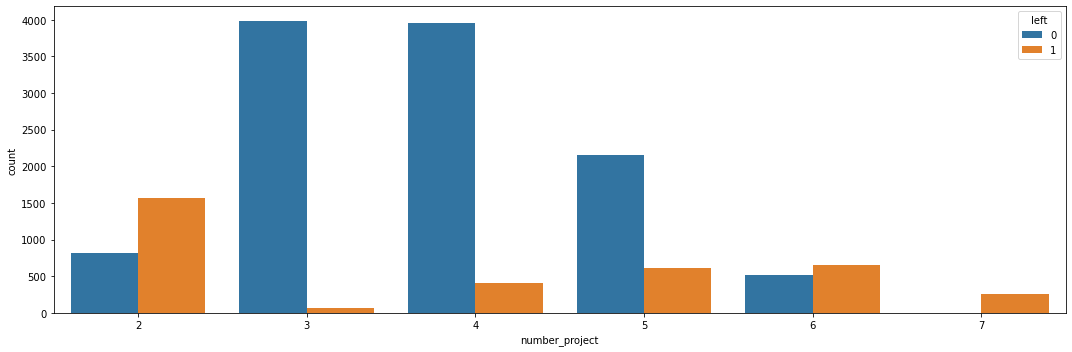

In [8]:
# Turnover by number of projects
plt.figure(figsize=(15,5))
sns.countplot(x='number_project', hue='left', data=hr)
plt.tight_layout()

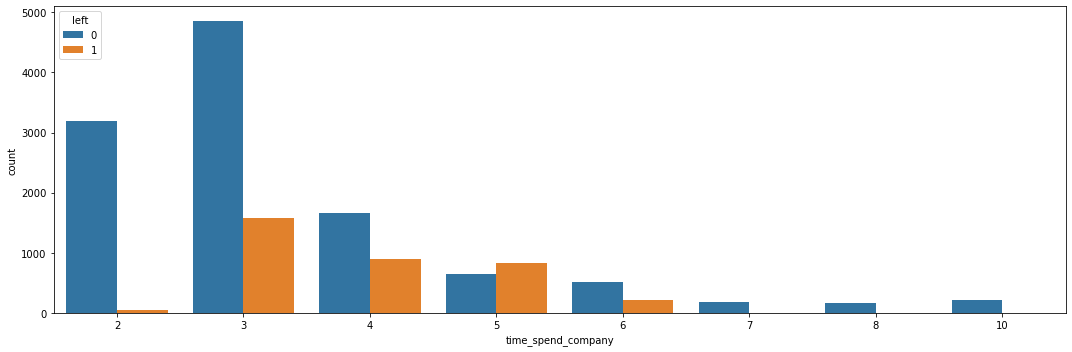

In [9]:
# Turnover by time spend in company
plt.figure(figsize=(15,5))
sns.countplot(x='time_spend_company', hue='left', data=hr)
plt.tight_layout()

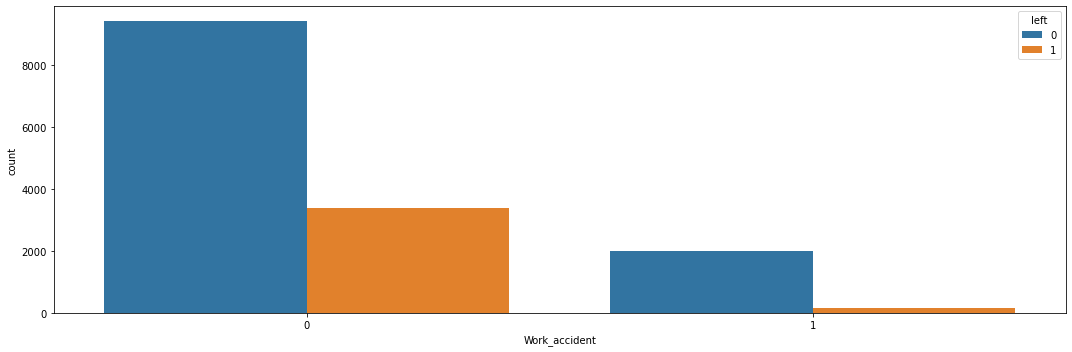

In [10]:
# Turnover by work accident
plt.figure(figsize=(15,5))
sns.countplot(x='Work_accident', hue='left', data=hr)
plt.tight_layout()

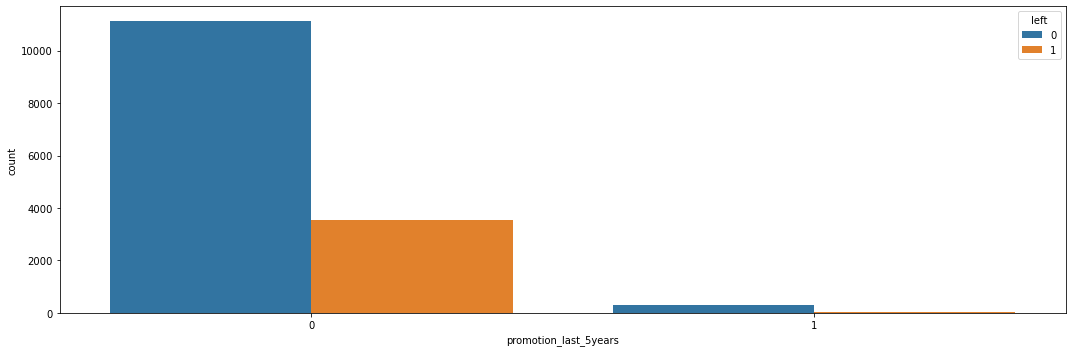

In [11]:
# Turnover by promotion in last 5 years
plt.figure(figsize=(15,5))
sns.countplot(x='promotion_last_5years', hue='left', data=hr)
plt.tight_layout()

In [12]:
print('Turnover Rate if Promotion:', round(len(hr[(hr['promotion_last_5years']==1)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==1)])*100,2),'%')
print('Turnover Rate if No Promotion:', round(len(hr[(hr['promotion_last_5years']==0)&(hr['left']==1)])/len(hr[(hr['promotion_last_5years']==0)])*100,2),'%')

Turnover Rate if Promotion: 5.96 %
Turnover Rate if No Promotion: 24.2 %


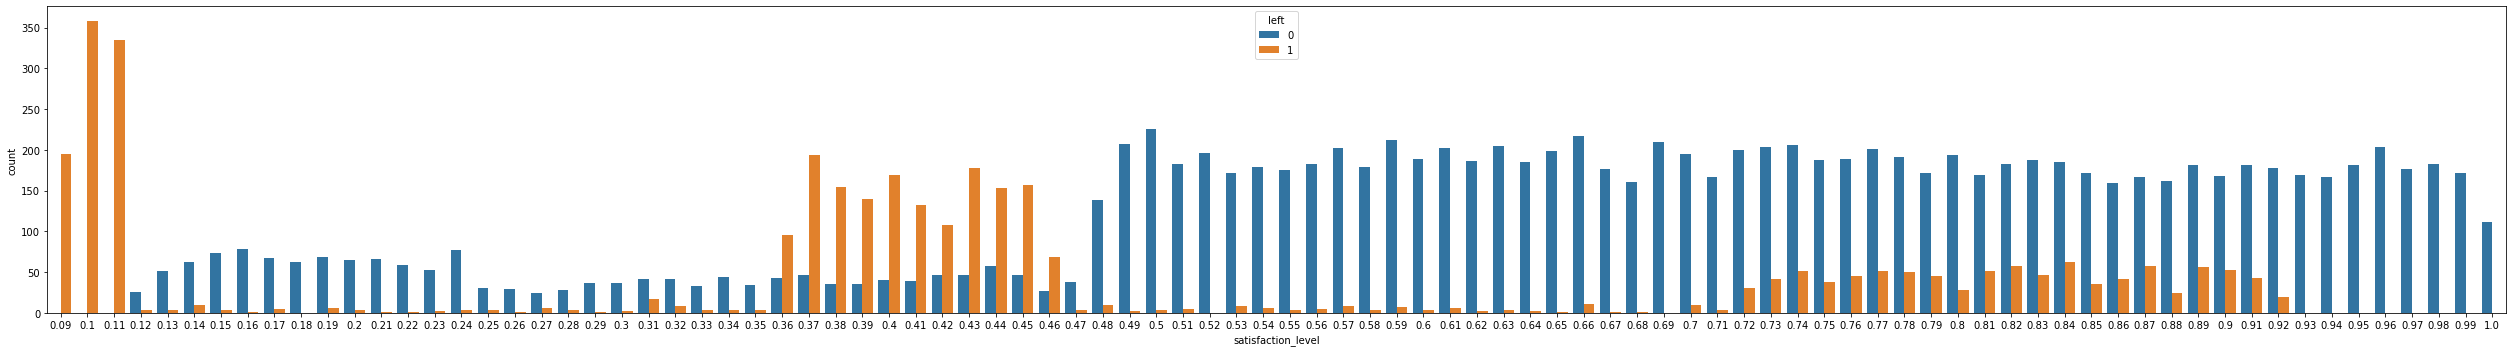

In [13]:
# Turnover by satisfaction level
plt.figure(figsize=(35,5))
sns.countplot(x='satisfaction_level', hue='left', data=hr)
plt.tight_layout()

Employees who left company have satisfaction level at 0.09-0.12, 0.36-0.46, 0.72-0.92 regions. In most of cases, lower satisfaction level leads to high turnover count

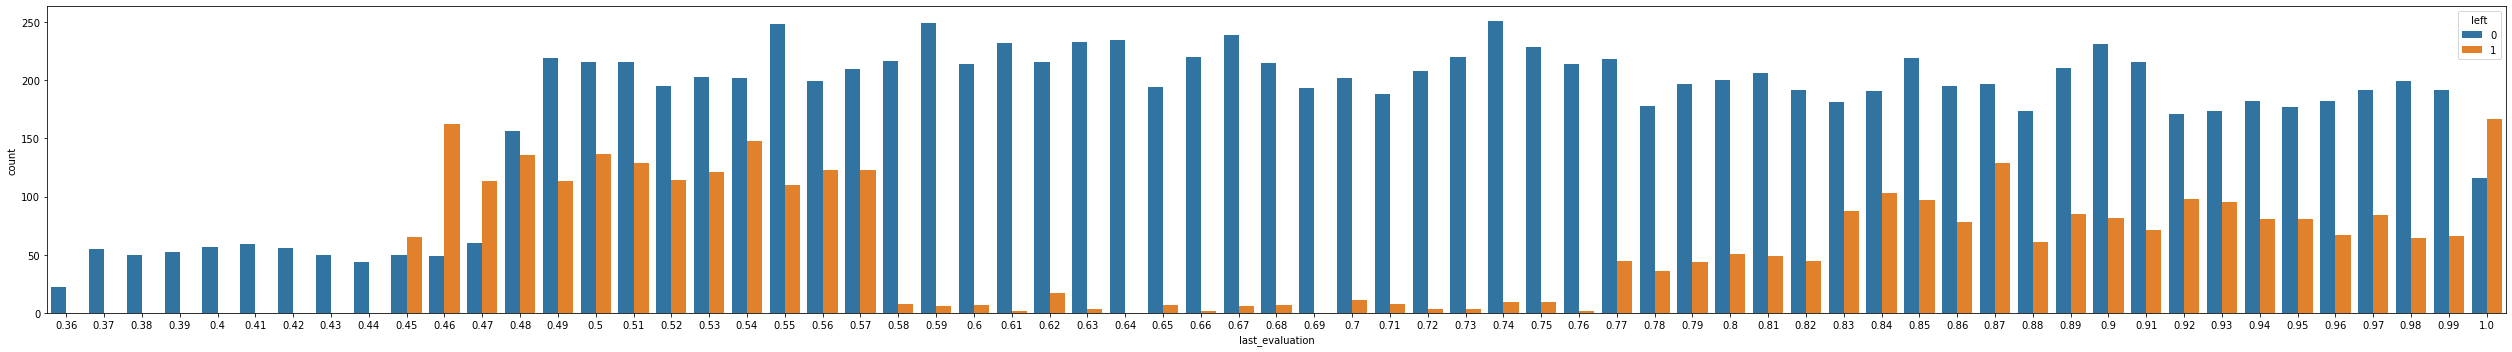

In [14]:
# Turnover by last evaluaction
plt.figure(figsize=(35,5))
sns.countplot(x='last_evaluation', hue='left', data=hr)
plt.tight_layout()

There are two regions in last evaluations with high turnover count: 0.45-0.57, and > 0.77, indicating employees with medium and high evaluations tend to leave.

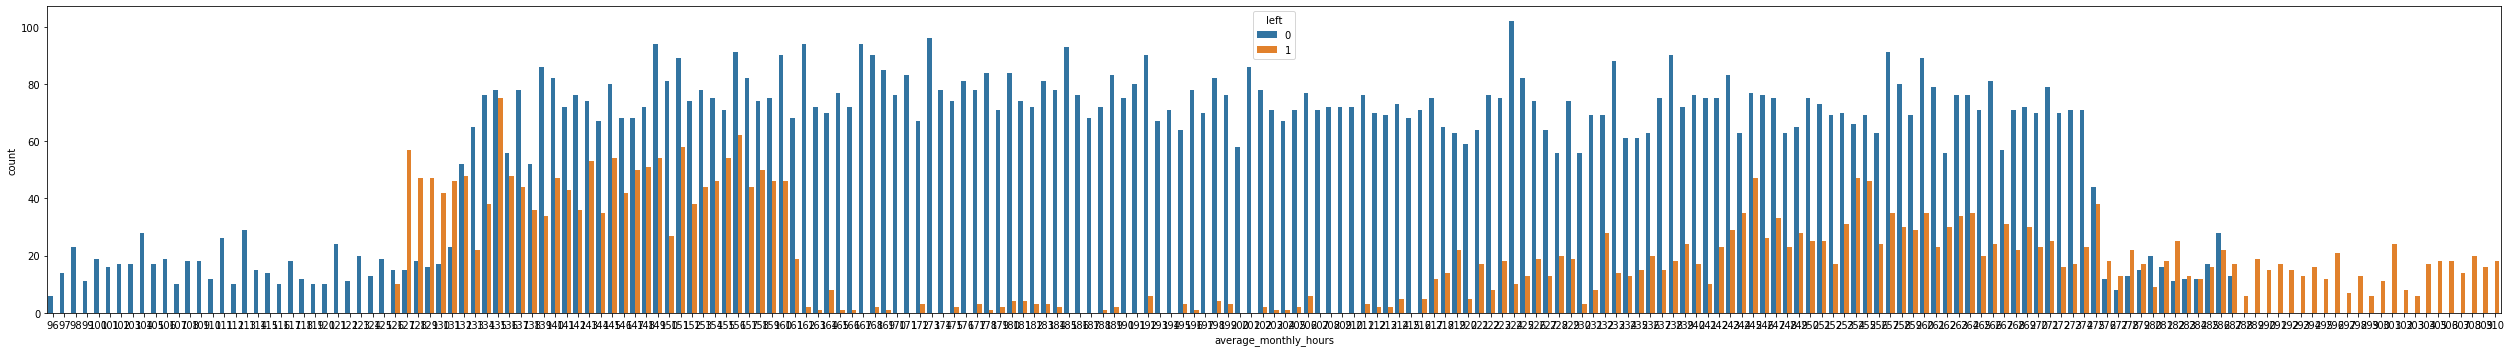

In [15]:
# Turnover by average monthly hours
plt.figure(figsize=(35,5))
sns.countplot(x='average_monthly_hours', hue='left', data=hr)
plt.tight_layout()

There are two high turnover regions in average monthly hours: 126-161 and > 275. For average monthly hours more than 288, turnover rate is 100%.

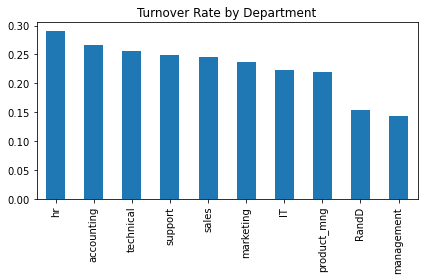

In [16]:
# Turnover by department
hr.groupby('Department')['left'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Turnover Rate by Department')
plt.xlabel('')
plt.tight_layout()

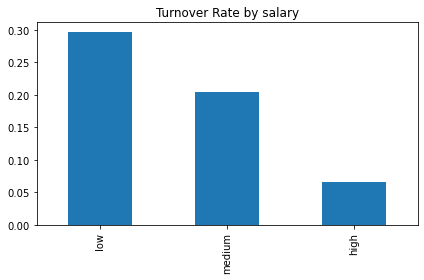

In [17]:
# Turnover by salary
hr.groupby('salary')['left'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Turnover Rate by salary')
plt.xlabel('')
plt.tight_layout()

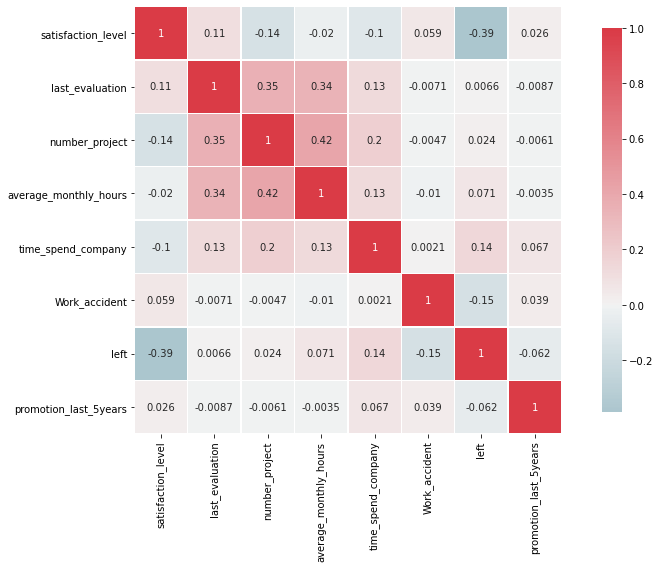

In [18]:
# Correlation matrix
plt.figure(figsize=(12,8))

# Generate a mask for the upper triangle
mask = np.zeros_like(hr.corr(), dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(hr.corr(), cmap=cmap, annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .9})
plt.tight_layout()

number_project has moderate positive correlation with average_monthly_hours 0.42;
number_project has moderate positive correlation with last_evaluation 0.35;
average_monthly_hours has moderate positive correlation with last_evaluation 0.33;
left has moderate negative correlation with satisfaction_level -0.39

Encoding Categorical Variables

The variable 'Salary' will be encoded using ordinal encoding and 'Department' with one-hot encoding.

In [19]:
# Encoding Salary
salary_dict = {'low': 0, 'medium': 1, 'high': 2}
hr['salary_num'] = hr.salary.map(salary_dict)
hr.drop('salary', inplace=True, axis=1)
hr = hr.rename(columns={'salary_num': 'salary'})
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0


In [20]:
# Encoding Department
cat_feats = ['Department']
final_data = pd.get_dummies(hr, columns=cat_feats)
#final_data.info()
final_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Scaling and Screwness

Numerical variables average_monthly_hours, last_evaluation and satisfaction_level are scaled to remove any influence of their difference in value ranges on the model.

In [21]:
scaler = preprocessing.MinMaxScaler()
hr_scaled = scaler.fit_transform(final_data[['satisfaction_level','last_evaluation','average_monthly_hours']])
hr_scaled = pd.DataFrame(hr_scaled, columns=list(['satisfaction_level','last_evaluation','average_monthly_hours']))

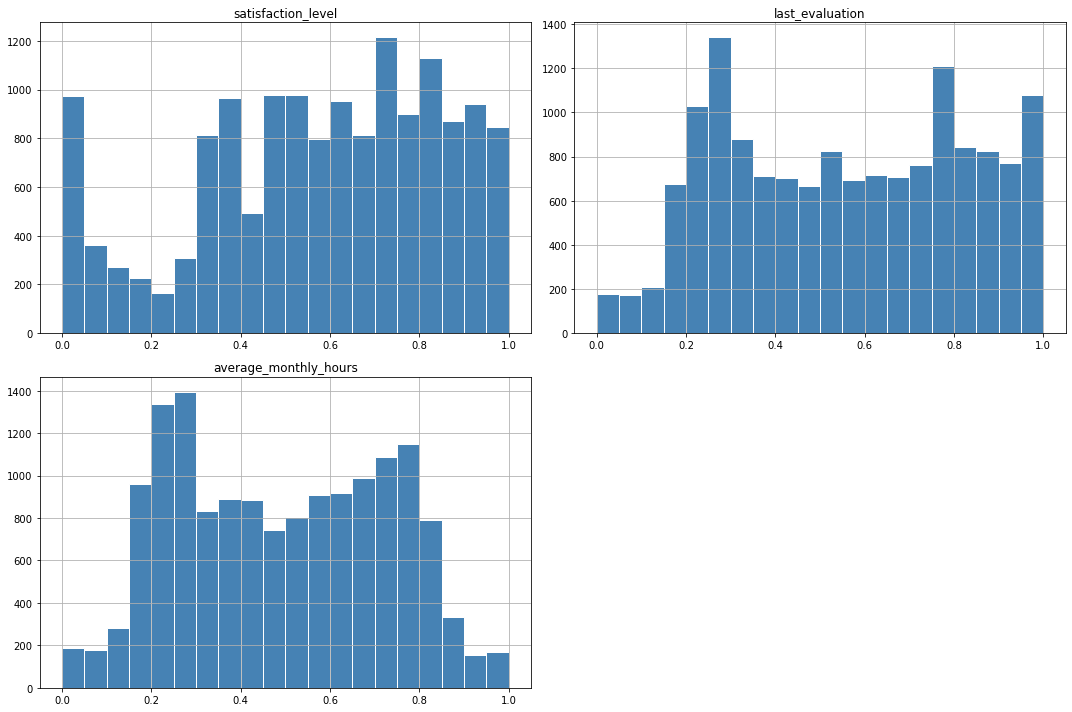

In [22]:
hr_scaled[['satisfaction_level',
                'last_evaluation',
                'average_monthly_hours']].hist(bins = 20, figsize = (15,10), color = 'steelblue', edgecolor='white')
plt.tight_layout()

In [23]:
hr_scaled.describe()

,satisfaction_level,last_evaluation,average_monthly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889
std,0.273220,0.267452,0.233379
min,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374
50%,0.604396,0.562500,0.485981
75%,0.802198,0.796875,0.696262
max,1.000000,1.000000,1.000000


Fix skewness

In [24]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: x.skew()).sort_values(ascending=False)
    skews = pd.DataFrame({'skewness':feature_skew})
    return feature_skew, numeric_features

In [25]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: x.skew()).sort_values(ascending=False)
    skews = pd.DataFrame({'skewness':skew_features})
    return df

In [26]:
hr_skewed = fix_skewness(hr_scaled)

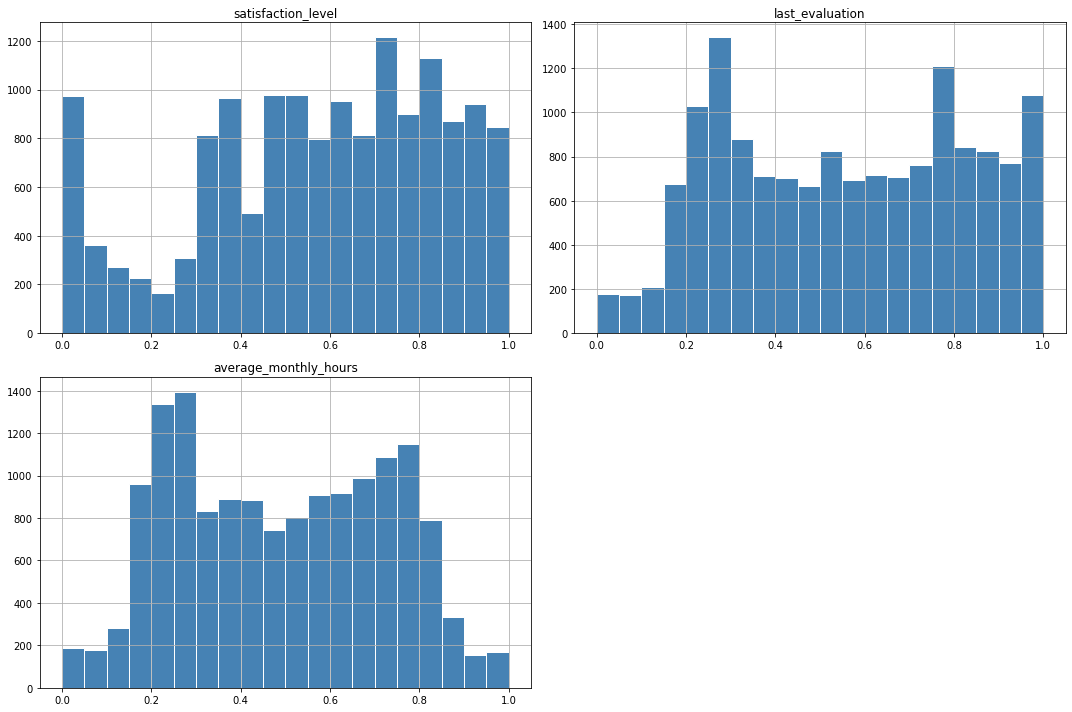

In [27]:
hr_skewed[['satisfaction_level',
                'last_evaluation',
                'average_monthly_hours']].hist(bins = 20, figsize = (15,10), color = 'steelblue', edgecolor='white')
plt.tight_layout()

In [28]:
hr_skewed.describe()

,satisfaction_level,last_evaluation,average_monthly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889
std,0.273220,0.267452,0.233379
min,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374
50%,0.604396,0.562500,0.485981
75%,0.802198,0.796875,0.696262
max,1.000000,1.000000,1.000000


The resulting values aren't different than the initial ones, showing that the data wasn't skewed.

In [29]:
hr_simple = final_data.copy()
hr_simple.drop(['satisfaction_level',
                'last_evaluation',
                'average_monthly_hours'], inplace=True, axis=1)

hr_ready = pd.DataFrame()
hr_simple.reset_index(drop=True, inplace=True)
hr_skewed.reset_index(drop=True, inplace=True)

hr_ready = pd.concat([hr_skewed,hr_simple], axis=1, sort=False, ignore_index=False)


hr_ready.head()

,satisfaction_level,last_evaluation,average_monthly_hours,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.318681,0.265625,0.285047,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.780220,0.781250,0.775701,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.021978,0.812500,0.822430,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.692308,0.796875,0.593458,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.307692,0.250000,0.294393,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [30]:
hr_ready.describe()

,satisfaction_level,last_evaluation,average_monthly_hours,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.490889,3.803054,3.498233,0.144610,0.238083,0.021268,0.594706,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345
std,0.273220,0.267452,0.233379,1.232592,1.460136,0.351719,0.425924,0.144281,0.637183,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317
min,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.280374,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,0.485981,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,0.696262,5.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,10.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


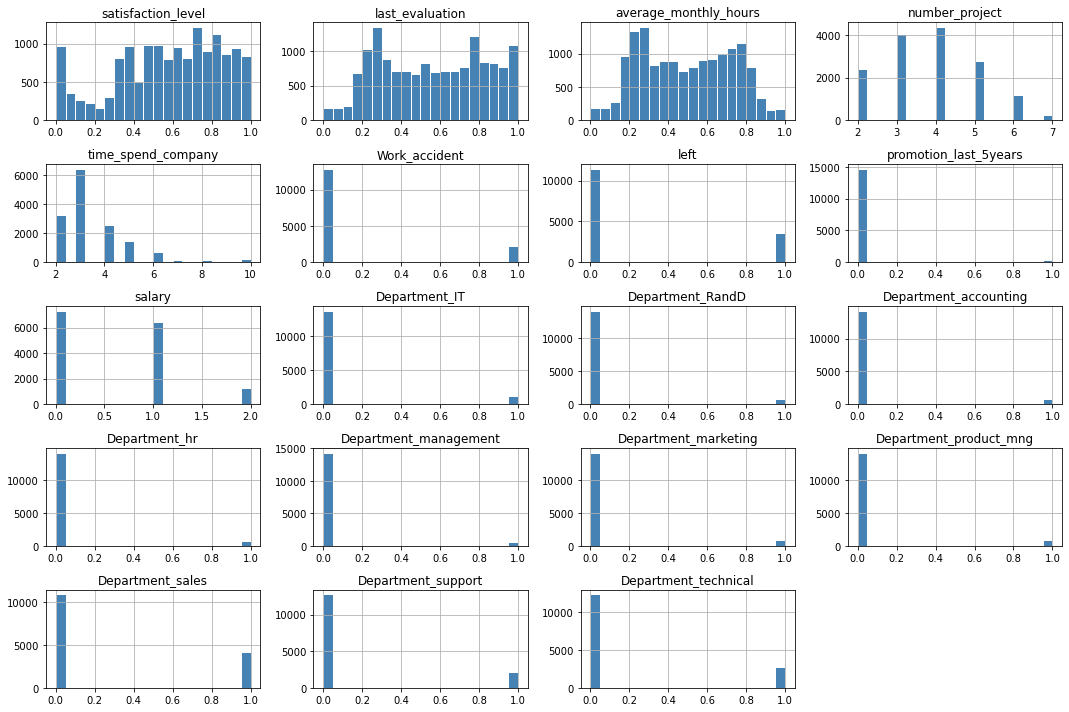

In [31]:
hr_ready.hist(bins = 20, figsize = (15,10), color = 'steelblue', edgecolor='white')
plt.tight_layout()

Training/Test Split

In [32]:
target = 'left'

split_ratio = 0.3
seed = 806

def split_dataset(df, target, split_ratio=0.3, seed=806):
    features = list(df)
    features.remove(target)
    
    X = df[features]
    y = df[[target]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_ratio, random_state = seed)
    
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = split_dataset(hr_ready, target, split_ratio, seed)

print('Features:', X.shape[0], 'items | ', X.shape[1], 'columns')
print('Target:', X.shape[0], 'items | ', X.shape[1], 'columns')
print('Features Train:', X_train.shape[0], 'items | ', X_train.shape[1], 'columns')
print('Features Test:', X_test.shape[0], 'items | ', X_test.shape[1], 'columns')
print('Target Train:', y_train.shape[0], 'items | ', y_train.shape[1], 'columns')
print('Target Test:', y_test.shape[0], 'items | ', y_test.shape[1], 'columns')

Features: 14999 items |  18 columns
Target: 14999 items |  18 columns
Features Train: 10499 items |  18 columns
Features Test: 4500 items |  18 columns
Target Train: 10499 items |  1 columns
Target Test: 4500 items |  1 columns


Logistic Regression Model

In [33]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 300)

In [34]:
def lr_run(model, X_train, X_test, y_train, y_test):
    result = model.fit(X_train, y_train.values.ravel())
    
    y_pred = model.predict(X_test)
    
    acc_test = model.score(X_test, y_test)
    
    coefficients = pd.concat([pd.DataFrame(X_train.columns, columns=['Feature']), pd.DataFrame(np.transpose(model.coef_), columns=['Coef.'])], axis = 1)
    coefficients.loc[-1] = ['intercept.', model.intercept_[0]]
    coefficients.index = coefficients.index + 1
    coefficients = coefficients.sort_index()
    
    print('Accuracy on test:{:.3f}'.format(acc_test))
    print('\n')
    print(classification_report(y_test, y_pred))
    print('\n')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\n')
    print(coefficients)

In [35]:
lr_run(lr, X_train, X_test, y_train, y_test)

Accuracy on test:0.797


              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3435
           1       0.63      0.34      0.44      1065

    accuracy                           0.80      4500
   macro avg       0.73      0.64      0.66      4500
weighted avg       0.78      0.80      0.77      4500



Confusion Matrix:
[[3220  215]
 [ 700  365]]


                   Feature     Coef.
0               intercept.  0.655178
1       satisfaction_level -3.617668
2          last_evaluation  0.439433
3    average_monthly_hours  0.910720
4           number_project -0.285436
5       time_spend_company  0.245407
6            Work_accident -1.395113
7    promotion_last_5years -1.192501
8                   salary -0.695676
9            Department_IT -0.067895
10        Department_RandD -0.475129
11   Department_accounting  0.068058
12           Department_hr  0.334216
13   Department_management -0.353498
14    Department_marketing  0.060789
15  Dep

Plot the ROC curve

In [36]:
def plot_roc(model, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show();

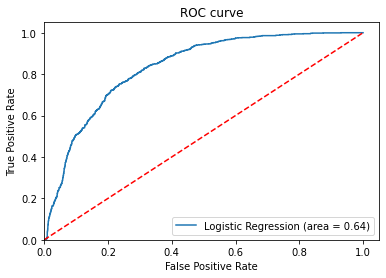

In [37]:
plot_roc(lr, X_test, y_test)